# Pulsar Folding and Searching 

Pulsar searching is a very time and compute intensive task. Searching for repeating signals within noisy data is a difficult issue alone, plus the fact massive volume of data and you got yourself a very difficult problem. 

This notebook illustrates the fundemental algorithms that are used for searching and detecting regular pusles within radio spectrograms. 

First we start off with downloading the data and `BLIMPY` which is an I/O tool developed to interface with the radio data!

In [0]:
!pip install blimpy
!wget http://blpd13.ssl.berkeley.edu/borisov/AGBT19B_999_124/spliced_blc40414243444546o7o0515253545556o7o061626364656667_guppi_58837_86186_PSR_B0355+54_0013.gpuspec.8.0001.fil
# !wget 	http://blpd13.ssl.berkeley.edu/borisov/AGBT19B_999_128/spliced_blc7071727374757677_guppi_58845_40114_PSR_B1133+16_0009.gpuspec.8.0001.fil
# http://ipta.phys.wvu.edu/files/student-week-2017/IPTA2017_KuoLiu_pulsartiming.pdf

# Loading Data

First we load the data. NOTE targets with the starting name of PSR are radio scans of known pulsars! On the other hand files starting with HIP are catelogued stars that shouldn't have pulsar characteristics. If you wish to learn more about the data checkout https://ui.adsabs.harvard.edu/abs/2019PASP..131l4505L/abstract

The header information gives vital info regarding the observational setup for the telescope. For example, the sensitivity of time or frequency or the range of frequency

blimpy.io.base_reader WARNING  Selection size of 8.17 GB, exceeding our size limit 1.00 GB. Instance created, header loaded, but data not loaded, please try another (t,v) selection.

--- File Info ---
     rawdatafile :                                 
     source_name :                     PSR_B0355+54
      machine_id :                               10
    telescope_id :                                6
         src_raj :                      3:58:53.496
         src_dej :                      54:13:14.88
        az_start :                              0.0
        za_start :                              0.0
       data_type :                                1
            fch1 :            11251.28173828125 MHz
            foff :                -0.3662109375 MHz
          nchans :                            10240
          nbeams :                                0
           ibeam :                                0
           nbits :                                8
   tstart (ISOT) : 

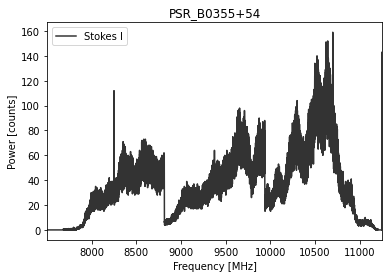

In [15]:
from blimpy import Waterfall
import pylab as plt
import numpy as np
import math
from scipy import stats, interpolate
from copy import deepcopy
%matplotlib inline


header = Waterfall('/content/spliced_blc40414243444546o7o0515253545556o7o061626364656667_guppi_58837_86186_PSR_B0355+54_0013.gpuspec.8.0001.fil',load_data=True)
header.info()

obs = Waterfall('/content/spliced_blc40414243444546o7o0515253545556o7o061626364656667_guppi_58837_86186_PSR_B0355+54_0013.gpuspec.8.0001.fil', 
               t_start=0,t_stop= 60000,max_load=10)
# Loads data into numpy array 
data = obs.data
data.shape
coarse_channel_width = np.int(np.round(187.5/64/abs(obs.header['foff'])))
# Here we plot the integrated signal over time.
obs.plot_spectrum()

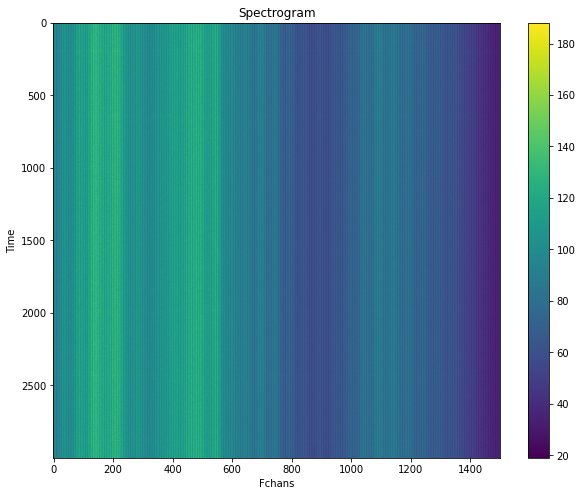

In [16]:
fig = plt.figure(figsize=(10,8))
plt.title('Spectrogram')
plt.xlabel("Fchans")
plt.ylabel("Time")
plt.imshow(data[:3000,0,1500:3000], aspect='auto')
plt.colorbar()

# De-Dispersion
When pulsar pulses reach Earth they actually reach the observer at different times because the radiation travels through an interstellar medium causing dispersion of the pulses. These appear as swooping curve instead of a straight horizontal lines. We need to correct them. We do so by calculating the delays per channel and shifting the values down. 

In [0]:
def delay_from_DM(DM, freq_emitted):
    if (type(freq_emitted) == type(0.0)):
        if (freq_emitted > 0.0):
            return DM / (0.000241 * freq_emitted * freq_emitted)
        else:
            return 0.0
    else:
        return Num.where(freq_emitted > 0.0,
                         DM / (0.000241 * freq_emitted * freq_emitted), 0.0)

def de_disperse(data,DM,fchan,width,tsamp):
  clean = deepcopy(data)
  for i in range(clean.shape[1]):
    end = clean.shape[0]
    freq_emitted = i*width+ fchan
    time = int((delay_from_DM(DM, freq_emitted))/tsamp)
    if time!=0 and time<clean.shape[0]:
      # zero_block = np.zeros((time))
      zero_block = clean[:time,i]
      shift_block = clean[:end-time,i]
      clean[time:end,i]= shift_block
      clean[:time,i]= zero_block

    elif time!=0:
      clean[:,i]= np.zeros(clean[:,i].shape)
  return clean

def DM_can(data, data_base, sens, DM_base, candidates, fchan,width,tsamp ):
  snrs = np.zeros((candidates,2))
  for i in range(candidates):
    DM = DM_base+sens*i
    data = de_disperse(data, DM, fchan,width,tsamp)
    time_series = data.sum(axis=1)
    snrs[i,1] = SNR(time_series)
    snrs[i,0] =DM
    if int((delay_from_DM(DM, fchan))/tsamp)+1 > data.shape[0]:
      break
    if i %1==0:
      print("Candidate "+str(i)+"\t SNR: "+str(round(snrs[i,1],4)) + "\t Largest Time Delay: "+str(round(delay_from_DM(DM, fchan), 6))+' seconds'+"\t DM val:"+ str(DM)+"pc/cm^3")
    data = data_base
  return snrs

In [0]:
# Functions to determine SNR and TOP candidates
def SNR(arr):
  index = np.argmax(arr)
  average_noise = arr.mean(axis=0)
  return math.log(arr[index]/average_noise) 

def top(arr, top = 10):
  candidate = []
  # Delete the first and second element fourier transform
  arr[0]=0
  arr[1]=0
  for i in range(top):
    index = np.argmax(arr)
    candidate.append(index)
    arr[index]=0
  return candidate  

Candidate 0	 SNR: 0.1402	 Largest Time Delay: 0.000369 seconds	 DM val:5.0pc/cm^3
Candidate 1	 SNR: 0.1405	 Largest Time Delay: 0.000376 seconds	 DM val:5.1pc/cm^3
Candidate 2	 SNR: 0.1414	 Largest Time Delay: 0.000383 seconds	 DM val:5.2pc/cm^3
Candidate 3	 SNR: 0.1428	 Largest Time Delay: 0.000391 seconds	 DM val:5.3pc/cm^3
Candidate 4	 SNR: 0.1451	 Largest Time Delay: 0.000398 seconds	 DM val:5.4pc/cm^3
Candidate 5	 SNR: 0.1488	 Largest Time Delay: 0.000406 seconds	 DM val:5.5pc/cm^3
Candidate 6	 SNR: 0.1536	 Largest Time Delay: 0.000413 seconds	 DM val:5.6pc/cm^3
Candidate 7	 SNR: 0.1561	 Largest Time Delay: 0.00042 seconds	 DM val:5.7pc/cm^3
Candidate 8	 SNR: 0.1569	 Largest Time Delay: 0.000428 seconds	 DM val:5.8pc/cm^3
Candidate 9	 SNR: 0.1588	 Largest Time Delay: 0.000435 seconds	 DM val:5.9pc/cm^3


Text(0, 0.5, 'SNR of Dedispersion')

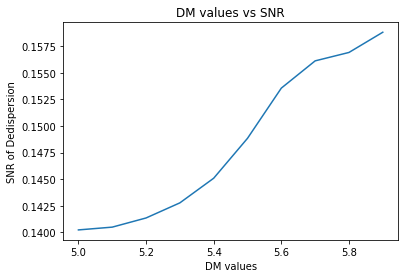

In [20]:
small_data = data[:,0,:]
data_base = data[:,0,:]
sens = 0.1
DM_base = 5
candidates = 10
fchan = obs.header['fch1']
width = obs.header['foff']
tsamp = obs.header['tsamp']
fchan = fchan+ width*small_data.shape[1]
snrs = DM_can(small_data, data_base, sens, DM_base, candidates, fchan, abs(width),tsamp)
plt.plot(snrs[:,0], snrs[:,1])
plt.title('DM values vs SNR')
plt.xlabel("DM values")
plt.ylabel("SNR of Dedispersion")

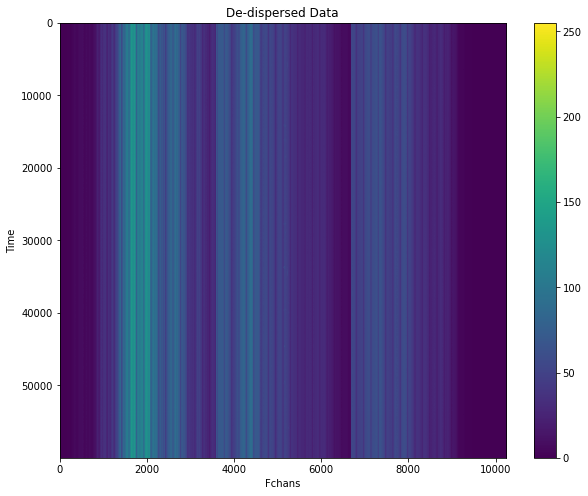

In [23]:
DM = snrs[np.argmax(snrs[:,1]),0]
fchan = fchan+ width*small_data.shape[1]
data[:,0,:] = de_disperse(data[:,0,:], DM, fchan,abs(width),tsamp)
fig = plt.figure(figsize=(10, 8))
plt.imshow(data[:,0,:], aspect='auto')
plt.title('De-dispersed Data')
plt.xlabel("Fchans")
plt.ylabel("Time")
plt.colorbar()
plt.show() 


# Band Pass Removal
To remove the bandpass, we use spline lines to fit each channel to obtain a model of the bandpass of that channel. By using splines, we are able to fit the bandpass without fitting the more significant signals. 

If you want more details on this checkout https://github.com/FX196/SETI-Energy-Detection for more detailed explantion  

Fitting Spline


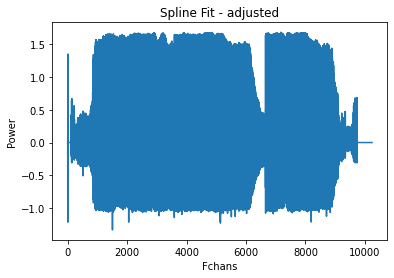

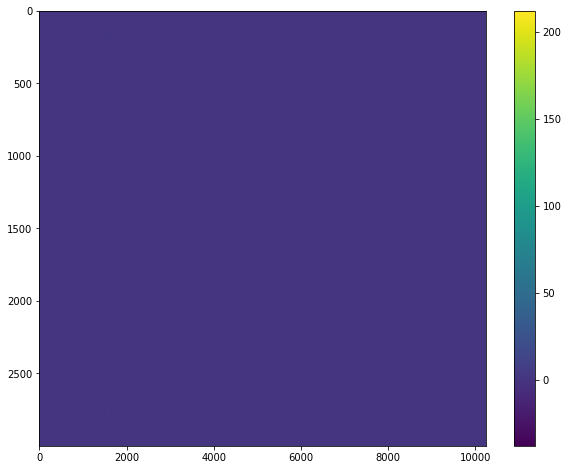

In [2]:
average_power = np.zeros((data.shape[2]))
shifted_power = np.zeros((int(data.shape[2]/8)))
x=[]
spl_order = 2
print("Fitting Spline")
data_adjust = np.zeros(data.shape)
average_power = data.mean(axis=0)

for i in range(0, data.shape[2], 8):
    average_channel = average_power[0,i:i+8]
    x = np.arange(0,coarse_channel_width,1)
    knots = np.arange(0, coarse_channel_width, coarse_channel_width//spl_order+1)

    tck = interpolate.splrep(x, average_channel, s=knots[1:])
    xnew = np.arange(0, coarse_channel_width,1)
    ynew = interpolate.splev(xnew, tck, der=0)
    data_adjust[:,0,i:i+8]  = data[:,0,i:i+8] - ynew

plt.figure()
plt.plot( data_adjust.mean(axis=0)[0,:])
plt.title('Spline Fit - adjusted')
plt.xlabel("Fchans")
plt.ylabel("Power")
fig = plt.figure(figsize=(10,8))
plt.imshow(data_adjust[:3000,0,:], aspect='auto')
plt.colorbar()

# Detecting Pulses - Fourier Transforms and Folding

What we do next is we take the fast fourier transform of the original signal and take the magnitude of the fourier transform. A large magnitude indicates a potential period within that signal. AKA a repeating signal! 

If the magnitude of the fourier transform is above a certain threshold we can consider it as a candidate. 


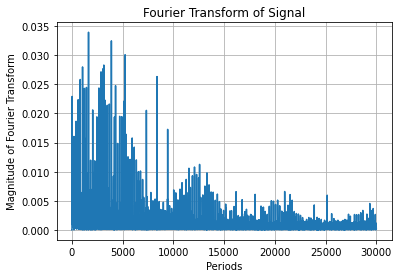

Signal To Noise Ratio for the Fourier Transform is: 3.680587016076327
Most likely Candidates are: [4194, 205, 2253, 1639, 2, 8389, 2048, 1229, 3, 1843, 1024, 4096, 4195, 1434, 2867]


In [27]:
#  Preforming the fourier transform.
%matplotlib inline
import scipy.fftpack
from scipy.fft import fft
N = 60000
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = data_adjust[:,0,:].mean(axis=1)
yf = fft(y)

xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

# Magintude of the fourier transform
# Between 0.00035 and 3.5 seconds
mag = np.abs(yf[:30000])
candidates = top(mag, top=15)
plt.plot(2.0/N * mag[1:])
plt.grid()
plt.title('Fourier Transform of Signal')
plt.xlabel("Periods")
plt.ylabel("Magnitude of Fourier Transform")
plt.show()

print("Signal To Noise Ratio for the Fourier Transform is: "+str(SNR(mag)))
print("Most likely Candidates are: "+str(candidates))

# Folding Algorithm 

The idea of the folding algorithm is to see if the signal forms a consistent profile as you fold / integrate the values together. If the profile appears consistent/stable then you're looking at an accurate reading of the pulsar's period! It is used to confirm the implications drawn from the fourier transform. It also forms a "finger print" of the pulsar!

![alt text](https://github.com/PetchMa/Pulsar_Folding/blob/master/assets/can_3.gif?raw=true)

0.9239826898229794


Text(0, 0.5, 'Normalized Integrated Signal')

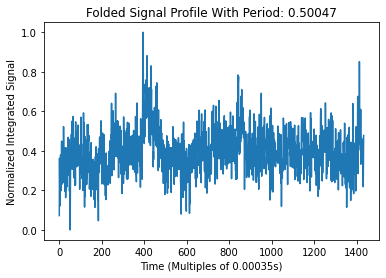

In [31]:
#  Lets take an example of such a period!
period = 1434
fold = np.zeros((period, data.shape[2]))
multiples = int(data.data.shape[0]/period)
results = np.zeros((period))

for i in range(multiples-1):
  fold[:,:]=data[i*period:(i+1)*period,0,:]+ fold

results = fold.mean(axis=1)
results = results - results.min()
results = results / results.max()

print(SNR(results))

plt.plot(results)
plt.title('Folded Signal Profile With Period: '+str(round(period*0.000349,5)))
plt.xlabel("Time (Multiples of 0.00035s)")
plt.ylabel("Normalized Integrated Signal")

The Signal To Noise of the Fold is: 0.9697247138696953


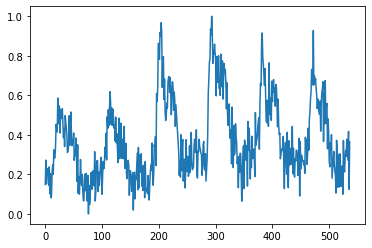

In [32]:
from scipy import stats 
data= data
period = 537
fold = np.zeros((period, data.shape[2]))
multiples = int(data.data.shape[0]/period)
results = np.zeros((period))

for i in range(multiples-1):
  fold[:,:]=data[i*period:(i+1)*period,0,:]+ fold
  results = fold.mean(axis=1)
  results = results - results.min()
  results = results / results.max()
  #  Generates multiple frames of the graph as it folds! 
  plt.plot(results)
  plt.title('Folded Signal Period '+str(period*0.000349)+" seconds| Fold Iteration: "+str(i))
  plt.xlabel("Time (Multiples of 0.00035s)")
  plt.ylabel("Normalized Integrated Signal")
  plt.savefig('/content/drive/My Drive/Deeplearning/Pulsars/output/candidates/CAN_3/multi_chan_'+str(period)+'_'+str(i)+'.png')
  plt.close()
  
results = fold.mean(axis=1)
results = results - results.min()
results = results / results.max()

print("The Signal To Noise of the Fold is: "+str(SNR(results)))
plt.plot(results)

# What Happens If The Data Doesn't Contain Pulses?

Below we will prove to you that this algorithm detects repeated pulses and excludes targets that do not include this feature! We will do so by loading a target that isn't known to contain pulsars.

Below we will rush through and apply the EXACT same algorithm but on a target that isn't a pulsar. 

In [10]:
!wget http://blpd13.ssl.berkeley.edu/dl/GBT_58402_64873_J1509+5531_time.h5

--2020-05-25 00:36:13--  http://blpd13.ssl.berkeley.edu/dl/GBT_58402_64873_J1509+5531_time.h5
Resolving blpd13.ssl.berkeley.edu (blpd13.ssl.berkeley.edu)... 208.68.240.55
Connecting to blpd13.ssl.berkeley.edu (blpd13.ssl.berkeley.edu)|208.68.240.55|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1366363942 (1.3G) [application/octet-stream]
Saving to: ‘GBT_58402_64873_J1509+5531_time.h5’

GBT_58402_64873_J15 100%[===================>]   1.27G   120MB/s    in 26s     

2020-05-25 00:36:39 (50.4 MB/s) - ‘GBT_58402_64873_J1509+5531_time.h5’ saved [1366363942/1366363942]



blimpy.io.base_reader WARNING  Selection size of 1.97 GB, exceeding our size limit 1.00 GB. Instance created, header loaded, but data not loaded, please try another (t,v) selection.

--- File Info ---
DIMENSION_LABELS : [b'frequency' b'feed_id' b'time']
        az_start :                              0.0
       data_type :                                1
            fch1 :                2720.80078125 MHz
            foff :                -0.3662109375 MHz
           ibeam :                                0
      machine_id :                               10
          nbeams :                                0
           nbits :                                8
          nchans :                             2464
            nifs :                                1
     rawdatafile :                                 
     source_name :                   PSR_J1509+5531
         src_dej :                     55:31:31.994
         src_raj :                      15:09:25.58
    telescope_id :

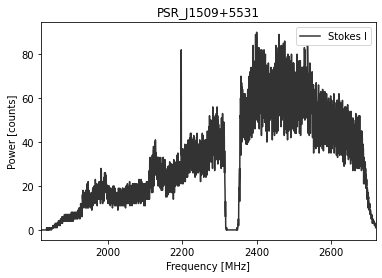

In [11]:
from blimpy import Waterfall
import pylab as plt
import numpy as np
import math
from scipy import stats, interpolate
%matplotlib inline


header = Waterfall('/content/GBT_58402_64873_J1509+5531_time.h5',load_data=True)
header.info()

obs = Waterfall('/content/GBT_58402_64873_J1509+5531_time.h5', 
               t_start=0,t_stop= 60000,max_load=10)
# Loads data into numpy array 
data = obs.data
data.shape
obs.plot_spectrum()

In [12]:
average_power = np.zeros((data.shape[2]))
shifted_power = np.zeros((int(data.shape[2]/8)))
x=[]
spl_order = 2
print("Fitting Spline")
data_adjust = np.zeros(data.shape)
average_power = data.mean(axis=0)

for i in range(0, data.shape[2], 8):
    average_channel = average_power[0,i:i+8]
    x = np.arange(0,coarse_channel_width,1)
    knots = np.arange(0, coarse_channel_width, coarse_channel_width//spl_order+1)

    tck = interpolate.splrep(x, average_channel, s=knots[1:])
    xnew = np.arange(0, coarse_channel_width,1)
    ynew = interpolate.splev(xnew, tck, der=0)
    data_adjust[:,0,i:i+8]  = data[:,0,i:i+8] - ynew

Fitting Spline


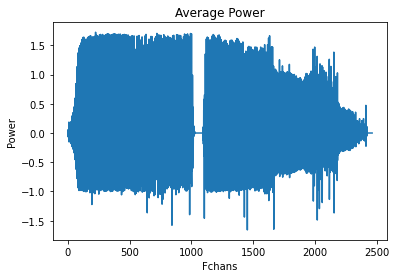

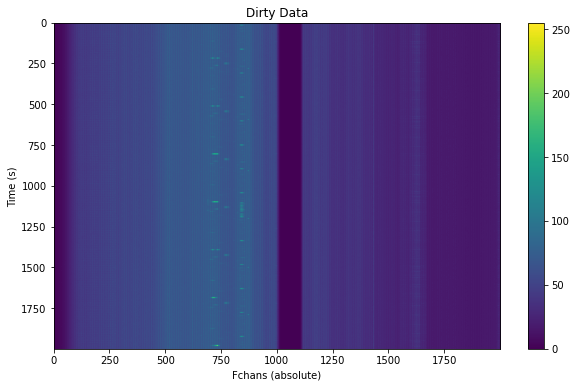

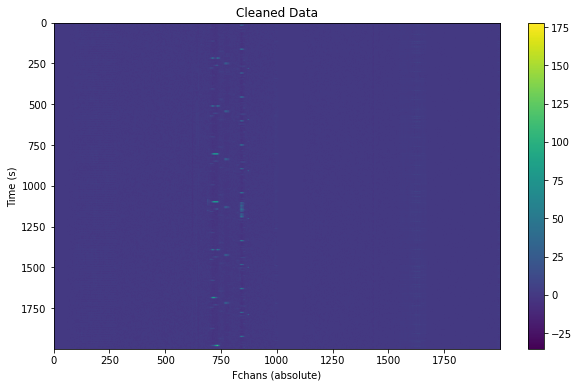

In [13]:
plt.figure()
plt.plot(data_adjust[:,0,:].mean(axis = 0))
plt.title('Average Power')
plt.xlabel("Fchans")
plt.ylabel("Power")



fig = plt.figure(figsize=(10, 6))
plt.imshow(data[:2000,0,:2000], aspect='auto')
plt.title('Dirty Data')
plt.xlabel("Fchans (absolute)")
plt.ylabel("Time (s)")
plt.colorbar()

fig = plt.figure(figsize=(10, 6))
plt.imshow(data_adjust[:2000,0,:2000], aspect='auto')
plt.title('Cleaned Data')
plt.xlabel("Fchans (absolute)")
plt.ylabel("Time (s)")
plt.colorbar()

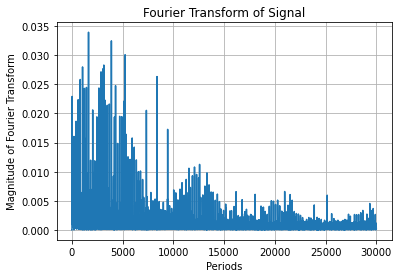

Signal To Noise Ratio for the Fourier Transform is: 3.680587016076327
Most likely Candidates are: [4194, 205, 2253, 1639, 2, 8389, 2048, 1229, 3, 1843, 1024, 4096, 4195, 1434, 2867]


In [14]:
#  Preforming the fourier transform.
%matplotlib inline
import scipy.fftpack
from scipy.fft import fft
N = 60000
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = data_adjust[:,0,:].mean(axis=1)
yf = fft(y)

xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

# Magintude of the fourier transform
# Between 0.00035 and 3.5 seconds
mag = np.abs(yf[:30000])
candidates = top(mag, top=15)
plt.plot(2.0/N * mag[1:])
plt.grid()
plt.title('Fourier Transform of Signal')
plt.xlabel("Periods")
plt.ylabel("Magnitude of Fourier Transform")
plt.show()

print("Signal To Noise Ratio for the Fourier Transform is: "+str(SNR(mag)))
print("Most likely Candidates are: "+str(candidates))


# NOTICE
Notice how the signal to noise ratio is a lot smaller. Typically with a SNR of less than 9, the likelyhood of a pulsar is very very low. 